In [2]:
from lib.ekyn import *
from torch.utils.data import DataLoader,ConcatDataset,TensorDataset
from lib.datasets import EpochedDataset
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.nn.functional import relu
from lib.models import YBlock,RegNetY
import math

In [3]:
CONFIG = {
    'BATCH_SIZE':256,
    'WINDOW_SIZE':5000,
    'LEARNING_RATE':3e-3,
    'TEST_SIZE':.25,
    'DEVICE':'cuda',
    'DEPTHI':[4,4,1,1],
    'WIDTHI':[4,8,16,32],
    'STEM_KERNEL_SIZE':7
}

In [4]:
snezana_mice_ids = get_snezana_mice_ids()
ekyn_ids = get_ekyn_ids()

In [5]:
trainloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='ekyn',id=id,condition='Vehicle'
                ) for id in ekyn_ids[:4]
        ] + 
        [
            EpochedDataset(
                dataset='snezana_mice',id=id
                ) for id in snezana_mice_ids[:4]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )

In [6]:
model = RegNetY(depth=CONFIG['DEPTHI'],width=CONFIG['WIDTHI'],stem_kernel_size=CONFIG['STEM_KERNEL_SIZE'])
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);
criterion.to(CONFIG['DEVICE']);
print(sum([p.flatten().size()[0] for p in list(model.parameters())]))

3639


In [7]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
ekynlossi = []
ekynf1 = []
micelossi = []
micef1 = []
model.train()
from lib.utils import training_loop,development_loop
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device=CONFIG['DEVICE'])
    trainlossi.append(loss)
    trainf1.append(f1)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
    ax[0].plot(trainlossi)
    ax[1].plot(trainf1)
    plt.savefig('loss.jpg')
    plt.close()

  0%|          | 0/1000 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [1]:
devloader = DataLoader(
    ConcatDataset(
        [
            EpochedDataset(
                dataset='ekyn',id=id,condition='Vehicle'
                ) for id in ekyn_ids[12:]
        ] +
        [
            EpochedDataset(
                dataset='snezana_mice',id=id
                ) for id in snezana_mice_ids[12:]
        ]
        ),batch_size=CONFIG['BATCH_SIZE'],shuffle=True
    )

NameError: name 'DataLoader' is not defined

100%|██████████| 135/135 [00:00<00:00, 210.93it/s]


              precision    recall  f1-score   support

         0.0       0.08      0.18      0.11      1683
         1.0       0.81      0.64      0.72     14913
         2.0       0.67      0.70      0.69     17964

    accuracy                           0.65     34560
   macro avg       0.52      0.51      0.50     34560
weighted avg       0.70      0.65      0.67     34560

3.73778674337599


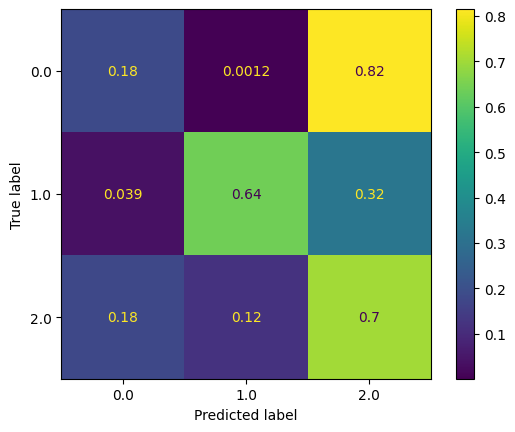

In [ ]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)